In [1]:
import cv2
import os
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image as Im
from IPython.display import display, Image, clear_output
from PIL import Image as Im
import time
import datetime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random  
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import torchvision.models as models
from torchmetrics import F1Score as F1

C:\Users\user\anaconda3\envs\TORCH\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    #os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.benchmark = True #включение cuDNN Autotuner
    #отключение отладок
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
seed_everything(42)
 
device

'cuda'

Чтение данных

In [4]:
# # Создаем папку для сохранения измененных изображений
# output_folder = r'I:\train\0'
# os.makedirs(output_folder, exist_ok=True)

# # Задаем порог для битых пикселей (в процентах)
# broken_pixel_threshold = 99

# def make_low_quality(image_path, output_path):
#     # Загружаем изображение
#     image = cv2.imread(image_path)

#     # Добавляем засветку (увеличиваем яркость)
#     image = cv2.convertScaleAbs(image, alpha=2, beta=50)

#     # Изменяем резкость
#     kernel = np.array([[-1,-1,-1], [-1,11,-1], [-1,-1,-1]])
#     image = cv2.filter2D(image, -1, kernel)

#     # Изменяем контрастность
#     alpha = 0.5  # Параметр контрастности (меньше 1.0 - уменьшает контрастность)
#     beta = 0    # Параметр яркости (0 - без изменений)
#     image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

#     # Генерируем случайные белые пятна
#     white_spots = np.random.rand(*image.shape[:2]) > 0.6  # Вероятность 10%
#     image[white_spots] = [255, 255, 255]  # Устанавливаем белый цвет

#     # Генерируем случайные черные пятна
#     black_spots = np.random.rand(*image.shape[:2]) > 0.9  # Вероятность 10%
#     image[black_spots] = [0, 0, 0]  # Устанавливаем черный цвет

#     # Сохраняем измененное изображение
#     cv2.imwrite(output_path, image)

# # Замените 'путь_к_папке_с_фото' на путь к вашей папке с изображениями
# input_folder = r'I:\train\2'

# # Получаем список файлов в папке
# image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

# # Обрабатываем каждое изображение
# for image_file in image_files:
#     image_path = os.path.join(input_folder, image_file)
#     output_path = os.path.join(output_folder, image_file)
#     make_low_quality(image_path, output_path)

# print("Изображения обработаны и сохранены в папке", output_folder)

In [5]:
def rename_files_in_folders(root_folder):
    count = 0
    for folder_name, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            old_path = os.path.join(folder_name, filename)
            new_name = os.path.splitext(filename)[0]  # Имя файла без расширения
            new_path = os.path.join(folder_name, f"train_new1_{count:04d}{os.path.splitext(filename)[1]}")
            count += 1
            
            try:
                os.rename(old_path, new_path)
                print(f'Переименован файл: {filename} в {new_name}{os.path.splitext(filename)[1]}')
            except Exception as e:
                print(f'Ошибка при переименовании файла {filename}: {e}')
fail = r'I:\train_new' # Замените 'путь_к_папке' на реальный путь к вашей папке с файлами

rename_files_in_folders(fail)

In [6]:
# Функция преобразования фоток к нужному размеру с использованием OpenCV
def process_images_in_folder(folder_path):
    file_number = 0
    for root, dirs, files in os.walk(folder_path):
        for file_name in tqdm(files):
            if file_name:
                file_path = os.path.join(root, file_name)
                try:
                    img = cv2.imread(file_path)
                    if img is not None:
                        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
                        cv2.imwrite(file_path, img)
                    else:
                        print(f"Could not read {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    
root_folder = r'I:\train_2class' # Замените 'путь_к_папке' на реальный путь к вашей папке с файлами
process_images_in_folder(root_folder)

In [7]:
# Удаление файлов
# def delete_copies(directory_path):
#     for root, directories, files in os.walk(directory_path):
#         for file in files:
#             if ' — копия' in file:
#                 file_path = os.path.join(root, file)
#                 os.remove(file_path)
#                 print(f'File {file} deleted.')

# directory_path = r'I:\val'  # Replace with your directory path

# delete_copies(directory_path)


In [8]:
def create_dataframe(folder_path):
    data = []

    for root, dirs, files in os.walk(folder_path):
        
        for file in files:
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            data.append((folder_name, file_path))

    df = pd.DataFrame(data, columns=['Folder Name', 'File Path'])
    return df


In [9]:
# Пример использования
folder_path = r"I:\train_2class"
df_train = create_dataframe(folder_path)
df_train['Folder Name'] = df_train['Folder Name'].astype(int)
df_train

,Folder Name,File Path
0,0,I:\train_2class\0\1034.JPG
1,0,I:\train_2class\0\1035.JPG
2,0,I:\train_2class\0\1036.JPG
3,0,I:\train_2class\0\1037.JPG
4,0,I:\train_2class\0\1038.JPG
...,...,...
44828,1,I:\train_2class\1\train_new1_1021.jpg
44829,1,I:\train_2class\1\train_new1_1022.jpg
44830,1,I:\train_2class\1\train_new1_1023.jpg
44831,1,I:\train_2class\1\train_new1_1024.jpg


<Axes: >

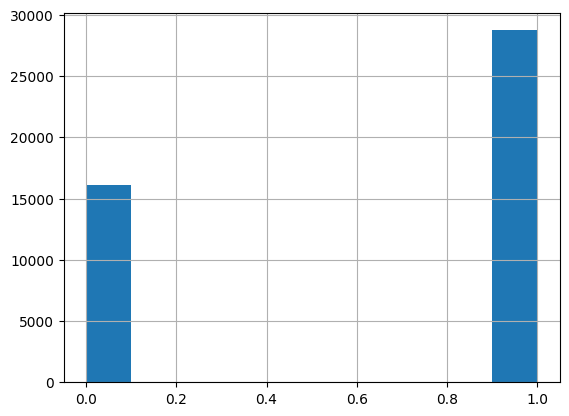

In [10]:
df_train['Folder Name'].hist()

In [11]:
# Пример использования
folder_path = r"I:\val_2_class"
df_val = create_dataframe(folder_path)
df_val['Folder Name'] = df_val['Folder Name'].astype(int)
df_val


,Folder Name,File Path
0,0,I:\val_2_class\0\1034.JPG
1,0,I:\val_2_class\0\1035.JPG
2,0,I:\val_2_class\0\1036.JPG
3,0,I:\val_2_class\0\1037.JPG
4,0,I:\val_2_class\0\1038.JPG
...,...,...
4182,1,I:\val_2_class\1\4182.JPG
4183,1,I:\val_2_class\1\4183.JPG
4184,1,I:\val_2_class\1\4184.JPG
4185,1,I:\val_2_class\1\4185.JPG


<Axes: >

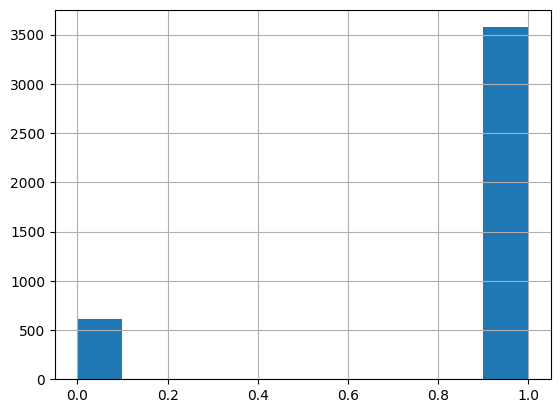

In [12]:
df_val['Folder Name'].hist()

Параметры фцнкции обучения

In [13]:
batch_size = 32 #размер батча
num_epochs = 10 #количество эпох
lr = 0.001 #шаг оптимизатора
num_classes = 2 #количество классов

Создадим датасет для обучения

In [14]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.csv_data = csv_file_path
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        image_filename = self.csv_data.iloc[index, 1]
        class_label = self.csv_data.iloc[index, 0]

        # Полный путь к файлу изображения
        image_path = os.path.join(image_filename)
        image = Im.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(int(class_label))

In [15]:
#Трансформации для изображений
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# data_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# Создание экземпляра датасета
train_dataset = CustomDataset(df_train, transform=data_transform)
val_dataset = CustomDataset(df_val, transform=data_transform)
# # Разделение на тренировочный и валидационный наборы с учетом дисбаланса классов
# validation_split = 0.2
# dataset_size = len(custom_dataset)
# validation_size = int(validation_split * dataset_size)
# train_size = dataset_size - validation_size

# # Получение индексов для разделения
# indices = list(range(dataset_size))
# random.shuffle(indices)  # Перемешиваем индексы перед разделением
# train_indices, validation_indices = indices[:train_size], indices[train_size:]

# Создание DataLoader для тренировочного и валидационного наборов
# num_workers = torch.multiprocessing.cpu_count()  # Использование всех доступных ядер
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size,  shuffle=False)

Функция обучения

In [16]:
def train_model(model, num_epochs, train_loader, valid_loader, device, lr):
    model = model.to(device)
    # Определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    f1_metric = F1(task="multiclass", num_classes=num_classes).to(device)  # num_classes - количество классов

    for epoch in range(num_epochs):
        start_time = time.time()  # Засекаем время начала эпохи
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            for param in model.parameters():
                param.grad = None
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                 
        model.eval()
        valid_loss = 0.0
        total_samples = 0.0
        correct_predictions = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
   
                # Обновляем метрику F1
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                f1_metric.update(predicted, labels)
                
                
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        # Получаем значение F1-меры
        f1_value = f1_metric.compute()
        epoch_duration = time.time() - start_time

        print(f"Epoch {epoch + 1} | Train_Loss: {running_loss / len(train_loader):.4f} | Valid_Loss: {valid_loss / len(valid_loader):.4f} | F1 Score: {f1_value:.4f} | AUC: {100 * correct_predictions / total_samples:.4f}| Time: {epoch_duration:.2f} seconds")

# Архитектуры с предобученными весами

## Архитектура EfficientNet

Предобученая архитектура EfficientNet-B4 из библиотеки torchvision

In [17]:
class Efficientnet_b4(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(Efficientnet_b4, self).__init__()
        self.efficientnet = models.efficientnet_b4 (weights="EfficientNet_B4_Weights.IMAGENET1K_V1")
        self.linear_layer = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.linear_layer(x)
        return x

In [18]:
efficient = Efficientnet_b4()
efficient = efficient.to(device)

In [23]:
#загрузка весов модели
efficient_train = Efficientnet_b4()
efficient_train.load_state_dict(torch.load('efficient_weights_2class.pth'))
efficient_train.eval()

Efficientnet_b4(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [ ]:
train_model(efficient, num_epochs, train_loader, valid_loader, device, lr)

Epoch 1 | Train_Loss: 0.0445 | Valid_Loss: 0.5643 | F1 Score: 0.8753 | AUC: 87.5328| Time: 7630.90 seconds


In [22]:
#сохраняем веса модели
efficient = efficient.to('cpu')
torch.save(efficient.state_dict(), 'efficient_weights_2class.pth')